# Import Packages

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Utilty Functions 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Base path:
base = '/content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/Semantic Segmentation data/data'

Mounted at /content/drive


In [ ]:
# Showing images in 2 columns based on a list
def show_img(img_list):
  fig, arr = plt.subplots(math.ceil(len(img_list)/2), 2, figsize=(15,8))
  if len(img_list) <= 2:
    for i in range(len(img_list)):
      arr[i%2].imshow(img_list[i])
      arr[i%2].axis('off')

  else:
    for i in range(len(img_list)):
      arr[(i//2)][i%2].imshow(img_list[i])
      arr[(i//2)][i%2].axis('off')

In [ ]:
classes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/Semantic Segmentation data/data/classes.csv',index_col='Unnamed: 0')

cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
def map_class_to_rgb(p): 
  return idx2rgb[p[0]]

# Quick Exploration

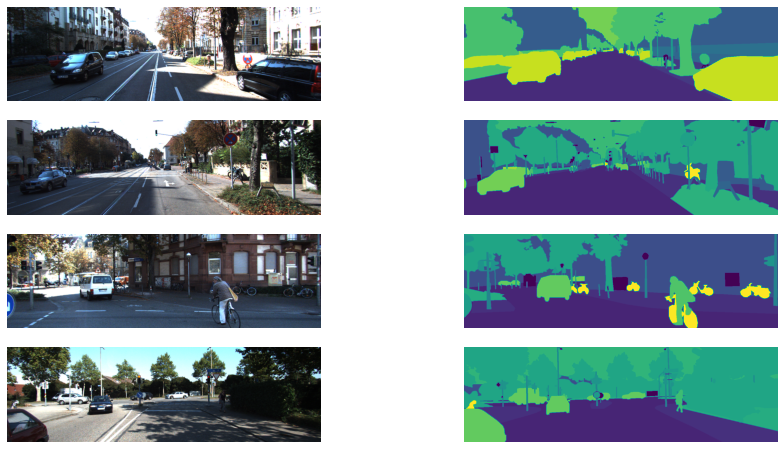

In [ ]:
# visualize some examples
img = plt.imread(os.path.join(base, 'training/image_2/000000_10.png'))
mask = plt.imread(os.path.join(base, 'training/semantic/000000_10.png'))

img1 = plt.imread(os.path.join(base, 'training/image_2/000001_10.png'))
mask1 = plt.imread(os.path.join(base, 'training/semantic/000001_10.png'))

img2 = plt.imread(os.path.join(base, 'training/image_2/000002_10.png'))
mask2 = plt.imread(os.path.join(base, 'training/semantic/000002_10.png'))

img3 = plt.imread(os.path.join(base, 'training/image_2/000008_10.png'))
mask3 = plt.imread(os.path.join(base, 'training/semantic/000008_10.png'))

show_img([img,mask,img1,mask1,img2,mask2,img3,mask3])

# Loading data and generating dataset

In [ ]:
# Creating list of images paths
img_list = os.listdir(os.path.join(base, 'training/image_2'))
mask_list = os.listdir(os.path.join(base, 'training/semantic'))

img_paths = []
for img in img_list:
  img_paths.append(os.path.join(base, 'training/image_2/'+img))

mask_paths = []
for mask in mask_list:
  mask_paths.append(os.path.join(base, 'training/semantic/'+mask))

img_paths = sorted(img_paths)
mask_paths = sorted(mask_paths)

number_of_images, number_of_masks = len(img_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {img_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 200 images and 200 masks in our dataset
2. An example of an image path is: 
 /content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/Semantic Segmentation data/data/training/image_2/000000_10.png
3. An example of a mask path is: 
 /content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/Semantic Segmentation data/data/training/semantic/000000_10.png


In [ ]:
# split the image paths into training and validation sets
train_image_paths, validation_image_paths, train_mask_paths, validation_mask_paths = train_test_split(img_paths, mask_paths, train_size=0.8, random_state=42)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')

There are 160 images in the Training Set
There are 40 images in the Validation Set


In [ ]:
# Generating dataset [Train - Validation] datasets
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 34

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    image_list = tf.constant(image_list) 
    mask_list = tf.constant(mask_list)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_image_paths, train_mask_paths)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths)

# Defining DeepLab-V3 Model

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

# Training model

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=25)

# Evaluation and Results

## Learning curves

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/models/deeplab_v3.h5')


# save model weights:
# model.save('/content/drive/MyDrive/Colab Notebooks/Graduation Project - Tekomoro/models/deeplab_v3.h5')

# Training Loss over epochs
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Training accuracy over epochs
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

# Validation Loss over epochs
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

# Validation accuracy over epochs
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

NameError: ignored

In [ ]:
for img, mask in validation_dataset.take(1):
  break

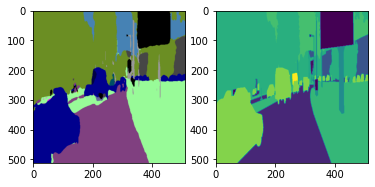

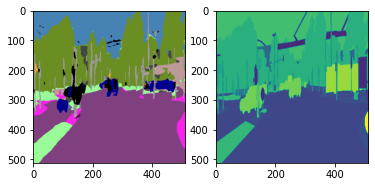

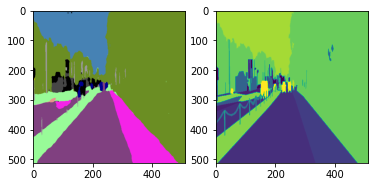

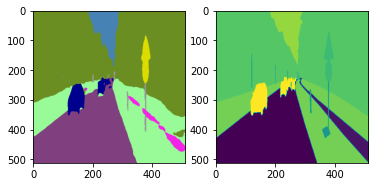

In [ ]:
preds = model.predict(img)
for i in range(preds.shape[0]):
    fig , ax = plt.subplots(1,2)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(preds[i], axis=-1), -1))
    ax[0].imshow(rgb_mask)
    ax[1].imshow(mask[i].numpy().reshape((512,512)))